In [ ]:
import numpy as np
import pandas as pd
from urllib import request
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
%matplotlib inline

#csvファイルからデータを入れる
#'/content/drive/Othercomputers/mac/teamF/app/after_scrape_results.csv'
#'/content/drive/MyDrive/Colab Notebooks/after_scrape_results.csv'
df = pd.read_csv('/content/drive/Othercomputers/mac/teamF/app/after_scrape_results.csv')
df.head()

In [ ]:
#データを整形
#価格を抽出
#税込の価格を取り出す。現在価格と即決価格があるときは現在価格を取り出す
current_price = [re.findall(r"\d+", i.replace(',', '')) for i in df['price']]
for j in range(len(current_price)):
  if current_price[j][1] == '0':
    current_price[j] = current_price[j][0]
  else:
    current_price[j] = current_price[j][1]
df["Price"] = pd.Series(current_price)
df["Price"].head()

In [ ]:
#時系列を抽出
time = [re.findall(r"\d+", i) for i in df['spec_table']]
year = []
month = []
date = []
hour = [] 
minute = []
for j in range(len(time)):
  year.append(int(time[j][6]))
  month.append(int(time[j][7]))
  date.append(int(time[j][8]))
  hour.append(int(time[j][9]))
  minute.append(int(time[j][10]))
df["year"] = pd.Series(year)
df["month"] = pd.Series(month)
df["date"] = pd.Series(date)
df["hour"] = pd.Series(hour)
df["minute"] = pd.Series(minute)
df.head()

In [ ]:
#要素を抽出
df = df.loc[:,['Price','month','date','hour']]
df

In [72]:
#データの型を確認
df.dtypes

Price    object
month     int64
date      int64
hour      int64
dtype: object

In [73]:
#float型に変換
df['Price'] = df['Price'].astype(float)
df.dtypes

Price    float64
month      int64
date       int64
hour       int64
dtype: object

In [74]:
#外れ値の処理
#両側5%を除外
q = df.Price.quantile(0.975)
r = df.Price.quantile(0.025)
df = df.query('Price < @q')
df = df.query('Price > @r')
df

,Price,month,date,hour
0,2750.0,8,23,11
2,19800.0,8,23,2
3,663.0,8,22,23
4,410.0,8,22,22
5,300.0,8,22,22
...,...,...,...,...
93,1500.0,8,4,21
94,400.0,8,4,21
96,1280.0,8,4,7
97,900.0,8,4,1


In [75]:
#データの順番を逆転・番号付け
df = df.iloc[::-1]
df.index = range(len(df))
df

,Price,month,date,hour
0,16629.0,8,3,21
1,900.0,8,4,1
2,1280.0,8,4,7
3,400.0,8,4,21
4,1500.0,8,4,21
...,...,...,...,...
89,300.0,8,22,22
90,410.0,8,22,22
91,663.0,8,22,23
92,19800.0,8,23,2


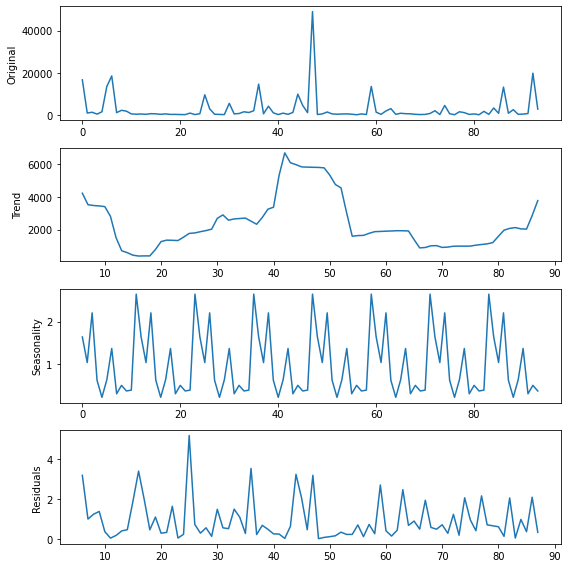

In [76]:
#時系列データの分解

res = sm.tsa.seasonal_decompose(df['Price'],freq =12, model='multiplicative')#データの指定
trend =res.trend  #トレンドデータ
seasonal =res.seasonal  #季節データ
residual = res.resid #残差データ

plt.figure(figsize=(8, 8)) #グラフ描画枠作成、サイズ指定

# 元の時系列データのプロット
plt.subplot(4,1,1) # グラフ4行1列の1番目の位置（一番上）
plt.plot(df['Price'])
plt.ylabel('Original')

# 傾向変動データのプロット
plt.subplot(4,1,2) # グラフ4行1列の2番目の位置
plt.plot(trend)
plt.ylabel('Trend')

# 季節変動データ のプロット
plt.subplot(4,1,3) # グラフ4行1列の3番目の位置
plt.plot(seasonal)
plt.ylabel('Seasonality')

# 不規則変動データのプロット
plt.subplot(4,1,4) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.tight_layout() # グラフの間隔を自動調整

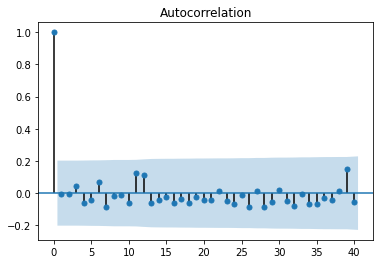

In [77]:
#コレログラムの表示
sm.graphics.tsa.plot_acf(df['Price'],lags=40)
plt.show()

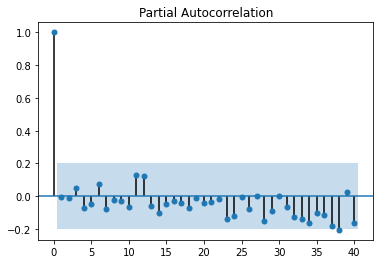

In [78]:
#偏自己相関係数の可視化
sm.graphics.tsa.plot_pacf(df['Price'],lags=40,method='ols')
plt.show()

In [79]:
#ADF検定
result = sm.tsa.stattools.adfuller(df['Price'])
print('P-value',result[1])

P-value 4.772741695435793e-17


In [80]:
#学習用データの分割
train_data =  df['Price'][:int(len(df)*0.8)]#8割のデータを検証に使う
test_data =  df['Price'][int(len(df)*0.8):]#2割のデータを検証に使う

In [81]:
#計算に3分ほど時間が必要
# SARIMAパラメータ最適化（総当たりチェック）
# パラメータ範囲
# 季節成分以外のパラメータ範囲
min_p = 1; max_p = 2 # min_pは1以上を指定しないとエラー
min_d = 0; max_d = 1
min_q = 0; max_q = 3 

# 季節成分のパラメータ範囲
min_P = 0; max_P = 1
min_D = 0; max_D = 1
min_Q = 0; max_Q = 1

test_pattern = (max_p - min_p +1)*(max_d - min_d + 1)*(max_q - min_q + 1)*(max_P - min_P + 1)*(max_D - min_D + 1)*(max_Q - min_Q + 1)
s = 12 # 季節周期パラメータ
data = train_data # 時系列データ

test_results = pd.DataFrame(index=range(test_pattern), columns=["model_parameters", "aic"])
num = 0
for p in tqdm(range(min_p, max_p + 1)):
    for d in range(min_d, max_d + 1):
        for q in range(min_q, max_q + 1):
            for P in range(min_P, max_P + 1):
                for D in range(min_D, max_D + 1):
                    for Q in range(min_Q, max_Q + 1):

                        sarima = sm.tsa.SARIMAX(
                                data, order=(p, d, q), 
                                seasonal_order=(P, D, Q, s), 
                                enforce_stationarity = False, 
                                enforce_invertibility = False
                            ).fit()
                        test_results.iloc[num]["model_parameters"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), seasonal_order=("+ str(P) + ","+ str(D) + "," + str(Q) + ")"
                        test_results.iloc[num]["aic"] = sarima.aic
                        num += 1
                        

# 結果（最小AiC）
print("best[aic] parameter ********")
print(test_results[test_results.aic == min(test_results.aic)])

100%|██████████| 2/2 [00:27<00:00, 13.53s/it]

best[aic] parameter ********
                          model_parameters      aic
123  order=(2,1,3), seasonal_order=(0,1,1)  973.016


In [82]:
model =  sm.tsa.SARIMAX(train_data,
                       order=(2,1,3),
                       seasonal_order=(0,1,1,12),
                       enforce_stationality=False,
                       enforce_invertibility=False
                       ).fit()
#SARIMAモデル（パラメータ最適化・総当たりaicベストを適用）

In [83]:
sarima_pre = model.forecast(int(len(df)*0.2)+1)#学習させたモデルで、すべてのデータを再現

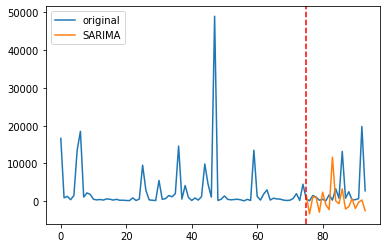

In [84]:
#原系列の表示
plt.plot(df['Price'], label='original')

#2年分の予測をを可視化
plt.plot(sarima_pre,label='SARIMA')
plt.axvline(x=len(train_data),c='r',linestyle='--')
plt.legend()
plt.show()

In [85]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data,sarima_pre))#検証用データを用いて、予測値の評価をする
print('予測値の誤差：',rmse)

予測値の誤差： 6162.388970239236
